For all the data present in the dataset

In [ ]:
#Prediction of drug type

In [ ]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.7 MB/s eta 0:00:00


In [ ]:
!pip install rdkit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 32.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/600, Loss: 0.7712451339657627, F1 Score: 0.36215213358070497, Training Accuracy: 0.5402514041187483
Epoch 2/600, Loss: 0.7088939605364158, F1 Score: 0.4082535003684598, Training Accuracy: 0.5704733886065793
Epoch 3/600, Loss: 0.6869922335912932, F1 Score: 0.43200601051840715, Training Accuracy: 0.5956138004814121
Epoch 4/600, Loss: 0.6856304798553239, F1 Score: 0.4110548851693266, Training Accuracy: 0.5953463492912543
Epoch 5/600, Loss: 0.6728779758090404, F1 Score: 0.41444270015698587, Training Accuracy: 0.600962824284568
Epoch 6/600, Loss: 0.6639625185461187, F1 Score: 0.41000410004100035, Training Accuracy: 0.6151377373629313
Epoch 7/600, Loss: 0.6588507868460755, F1 Score: 0.4187725631768954, Training Accuracy: 0.6124632254613533
Epoch 8/600, Loss: 0.6530953227584042, F1 Score: 0.40806045340050384, Training Accuracy: 0.6228938218775073
Epoch 9/600, Loss: 0.6575586066317203, F1 Score: 0.4321528054118583, Training Accuracy: 0.6183471516448248
Epoch 10/600, Loss: 0.64584705811

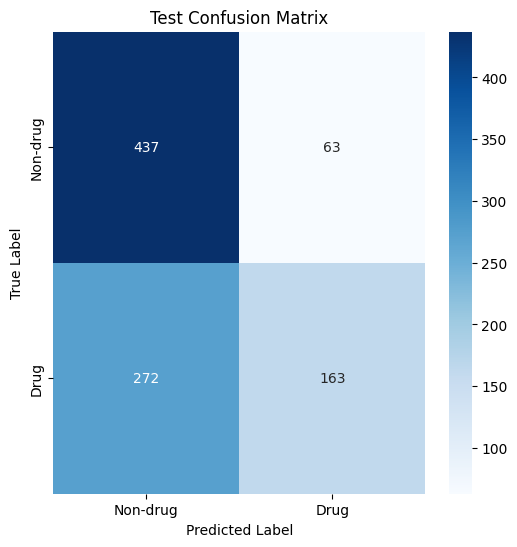

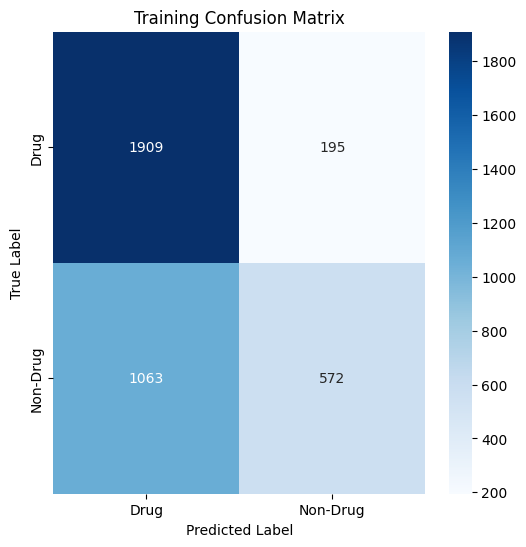

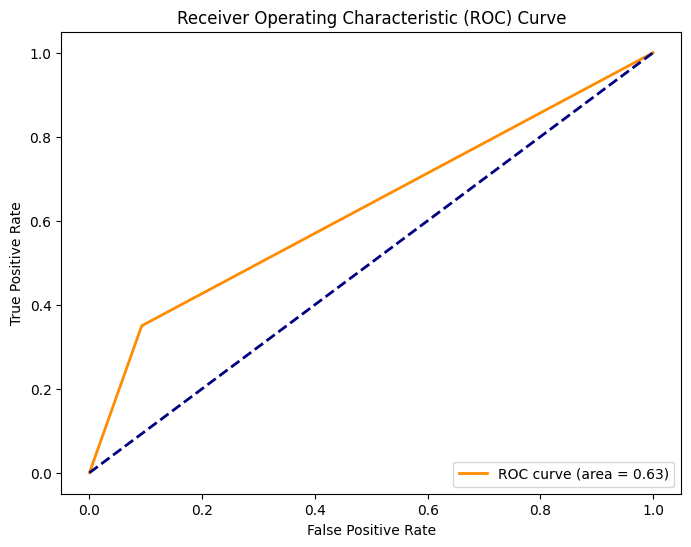

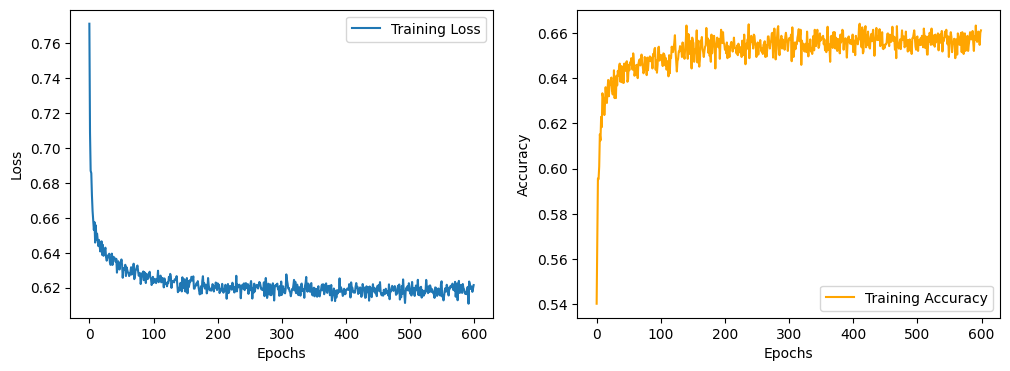

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GraphConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem

# Load your dataset
data = pd.read_csv('/content/molecule_properties (4).csv')

# Split data into SMILES and labels
smiles_list = data['SMILES'].tolist()
drug_labels = (data['Drug Type'] == 'Drug').astype(int).tolist()

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

def mol_to_graph(mol):
    num_atoms = mol.GetNumAtoms()

    # Extract atom features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.extend([atom.GetAtomicNum(),
                              atom.GetDegree(),
                              atom.GetFormalCharge(),
                              atom.GetImplicitValence(),
                              atom.GetIsAromatic(),
                              atom.GetMass(),
                              atom.GetNumExplicitHs(),
                              atom.GetNumImplicitHs(),
                              atom.GetNumRadicalElectrons(),
                              atom.GetTotalNumHs(),
                              atom.GetHybridization(),
                              atom.GetExplicitValence(),
                              atom.GetIsotope(),
                              atom.GetChiralTag(),
                              atom.GetTotalValence()])

    x = np.array(atom_features).reshape(-1, len(atom_features) // num_atoms)

    # Extract bond features
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # Assuming an undirected graph
        edge_attr.extend([bond.GetBondTypeAsDouble(),
                          bond.GetIsConjugated(),
                          bond.IsInRing()])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 3)

    # Create a Data object
    data = Data(x=torch.tensor(x, dtype=torch.float), edge_index=edge_index, edge_attr=edge_attr)

    return data

# Create a list of graphs
graphs = [mol_to_graph(mol) for mol in mols]

# Split data into training and testing sets
train_graphs, test_graphs, train_labels, test_labels = train_test_split(graphs, drug_labels, test_size=0.2, random_state=42)

# Define dataset and dataloaders
class MolGraphDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        graph = self.graphs[idx]
        label = self.labels[idx]
        return graph, label

# Create dataloaders
train_dataset = MolGraphDataset(train_graphs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=28, shuffle=True)
test_dataset = MolGraphDataset(test_graphs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=28, shuffle=False)

# Define the model architecture
class DynamicGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(DynamicGCN, self).__init__()

        self.graph_convs = nn.ModuleList([
            GraphConv(input_dim, hidden_dim),
            GraphConv(hidden_dim, hidden_dim),
        ])

        self.dropouts = nn.ModuleList([
            nn.Dropout(dropout_rate),
            nn.Dropout(dropout_rate),
        ])

        self.dense = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Check if edge_index has only 1 dimension
        if edge_index.dim() == 1:
            return torch.zeros_like(x[:, :1]).to(x.device).requires_grad_()

        for conv, dropout in zip(self.graph_convs, self.dropouts):
            x = conv(x, edge_index)
            x = torch.relu(x)
            x = dropout(x)

        x = global_mean_pool(x, batch)
        output = self.dense(x)
        return output

# Instantiate the model
model = DynamicGCN(input_dim=15, hidden_dim=64, output_dim=1, dropout_rate=0.5)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Adjusted learning rate and weight decay

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)  # Reduce learning rate by half every 50 epochs

# Training loop
num_epochs = 600
train_losses = []
train_accuracies = []
f1_scores = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    all_predictions = []
    all_labels = []

    for batch_data in train_loader:
        optimizer.zero_grad()
        input_features, labels = batch_data[0], batch_data[1]
        output = model(input_features)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        epoch_loss += loss.item()

        predictions = torch.sigmoid(output).round().squeeze().cpu().detach().numpy()
        labels = labels.cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels)

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    f1 = f1_score(all_labels, np.round(all_predictions))
    f1_scores.append(f1)

    train_accuracy = accuracy_score(all_labels, np.round(all_predictions))
    train_accuracies.append(train_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss}, F1 Score: {f1}, Training Accuracy: {train_accuracy}')
    scheduler.step()  # Step the scheduler

# Evaluation
model.eval()
all_predictions = []
all_labels = []

for batch_data in test_loader:
    input_features, labels = batch_data[0], batch_data[1]
    output = model(input_features)
    predictions = torch.sigmoid(output).round().squeeze().cpu().detach().numpy()
    labels = labels.cpu().numpy()
    all_predictions.extend(predictions)
    all_labels.extend(labels)

# Calculate test accuracy
test_accuracy = accuracy_score(all_labels, np.round(all_predictions))
print(f'Test Accuracy: {test_accuracy}')

# Confusion matrix for test data
conf_matrix_test = confusion_matrix(all_labels, np.round(all_predictions))
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-drug', 'Drug'], yticklabels=['Non-drug', 'Drug'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Confusion matrix for training data
model.eval()
all_predictions = []
all_labels = []

for batch_data in train_loader:
    input_features, labels = batch_data[0], batch_data[1]
    output = model(input_features)
    predictions = torch.sigmoid(output).round().squeeze().cpu().detach().numpy()
    labels = labels.cpu().numpy()
    all_predictions.extend(predictions)
    all_labels.extend(labels)

conf_matrix_train = confusion_matrix(all_labels, np.round(all_predictions))
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Drug', 'Non-Drug'], yticklabels=['Drug', 'Non-Drug'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Training Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotting training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
